In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torch.utils.tensorboard import SummaryWriter
from time import time

import utils.data as du
import utils.training as tut
from utils.models.wgan import Critic, Generator, initialize_weights

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 1.10.2
Device: cuda


In [2]:
# Hyperparameters etc.
INFO_FREQ = 2
LEARNING_RATE = 1e-4
BATCH_SIZE = 256
CHANNELS_IMG = 1
LATENT_DIM = 128
EPOCHS = 10
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

CHECKPOINT_PATH = "./checkpoints/wgan_checkpoint.pth.tar"

In [3]:
gen_model = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN, "Conv-Generator").to(device)
critic_model = Critic(CHANNELS_IMG, FEATURES_CRITIC, "Conv-Critic").to(device)
initialize_weights(gen_model)
initialize_weights(critic_model)

for model in [gen_model, critic_model]:
    tut.print_model_summary(model)

opt_gen = optim.Adam(gen_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9) )
opt_critic = optim.Adam(critic_model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9) )

fixed_noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)

Block name: Conv-Generator
----------------------------------------
 | LayerName | 	 | Size | 	 | Nparams | 
gen_net.0.0.weight: 	 (128, 256, 3, 3), 	 294912
gen_net.1.0.weight: 	 (256, 256, 3, 3), 	 589824
gen_net.2.0.weight: 	 (256, 128, 3, 3), 	 294912
gen_net.3.0.weight: 	 (128, 128, 3, 3), 	 147456
gen_net.4.0.weight: 	 (128, 1, 3, 3), 	 1152
Total parameters: 1328256
Trainable parameters: 1328256
Non-trianable parameters: 0

Block name: Conv-Critic
----------------------------------------
 | LayerName | 	 | Size | 	 | Nparams | 
critic_net.0.0.weight: 	 (64, 1, 3, 3), 	 576
critic_net.1.0.weight: 	 (128, 64, 3, 3), 	 73728
critic_net.2.0.weight: 	 (128, 128, 3, 3), 	 147456
critic_net.3.0.weight: 	 (256, 128, 3, 3), 	 294912
critic_net.4.0.weight: 	 (256, 256, 3, 3), 	 589824
critic_net.5.weight: 	 (1, 256, 3, 3), 	 2304
critic_net.5.bias: 	 (1,), 	 1
Total parameters: 1108801
Trainable parameters: 1108801
Non-trianable parameters: 0



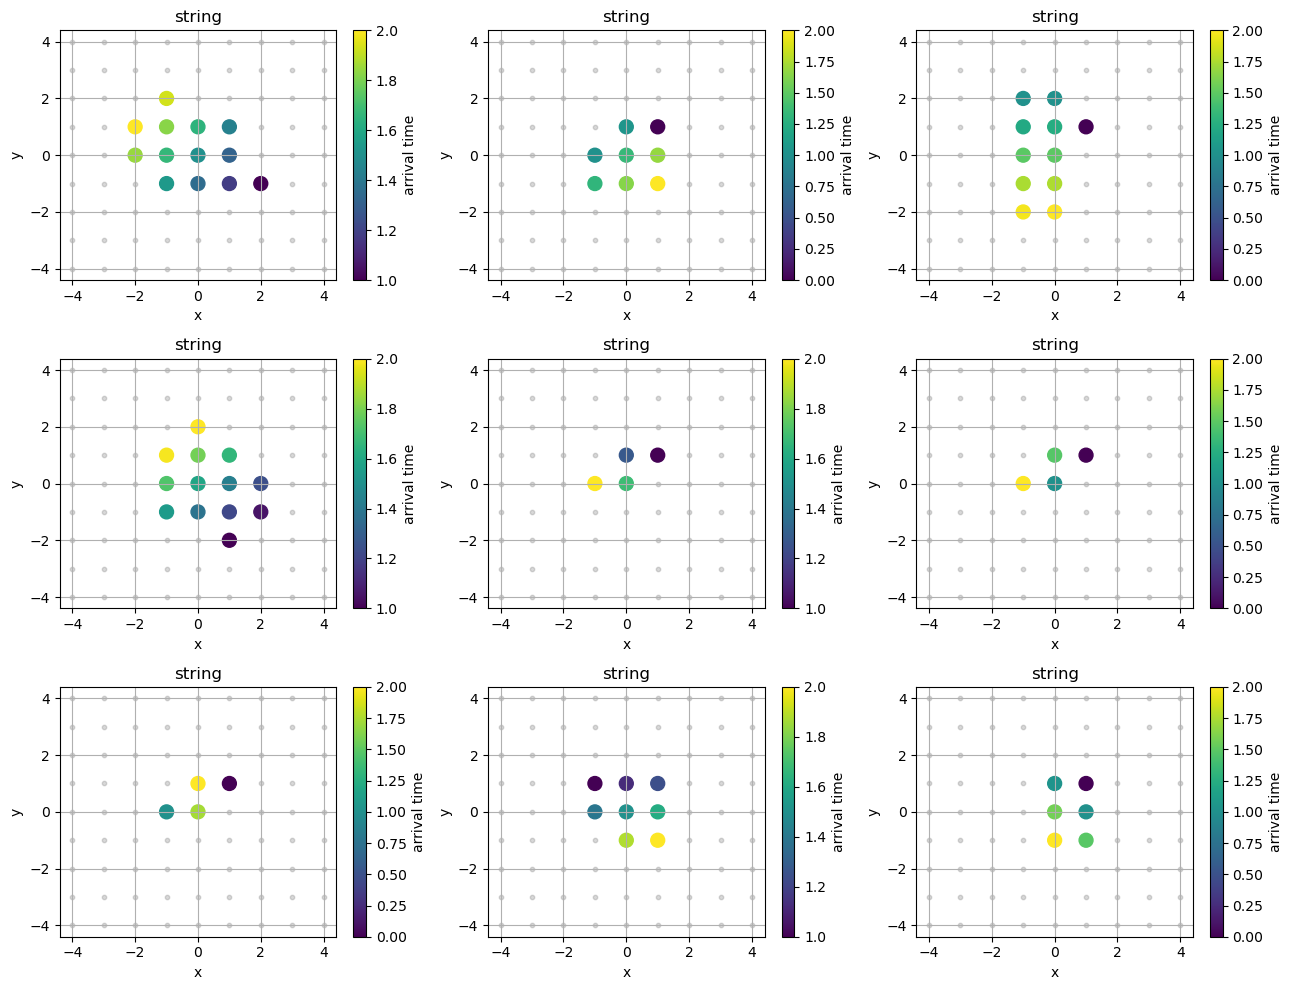

In [4]:
detectors_signals, arrival_times, logE, mass, xmax = du.get_data()

# arrival_times = du.proposedArrivalTimesNorm(arrival_times)
shower_maps = du.arrivalTimesDomMap(arrival_times)
shower_maps = shower_maps.reshape(-1, 1, 9, 9)
# total_signals = du.proposedTotalSignals(detectors_signals)

plot = du.plot_signals_arrival_times(arrival_times, N=3, random=True , show=True)

In [5]:
train_set = torch.from_numpy(shower_maps).type(torch.float32)
train_set = TensorDataset(train_set)
dataloader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

writer_real = SummaryWriter(f"logs/WGANGP_EAS/real")
writer_fake = SummaryWriter(f"logs/WGANGP_EAS/fake")
writer_scalar = SummaryWriter(f"logs/WGANGP_EAS/losses")

In [6]:
step = 0

gen_model.train()
critic_model.train()

for epoch in range(EPOCHS):
    start_time = time()
    for batch_idx, (real, ) in enumerate(dataloader):
        real = real.to(device)
        current_batch_size = real.shape[0]

        # Train critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(current_batch_size, LATENT_DIM, 1, 1).to(device)
            fake = gen_model(noise)
            critic_real = critic_model(real).reshape(-1)
            critic_fake = critic_model(fake).reshape(-1)
            gp = tut.gradient_penalty(critic_model, real, fake, device=device)
            loss_critic = ( -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp )
            critic_model.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
        
        # Train generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic_model(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen_model.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        tut.print_batches_progress_bar(batch_idx, len(dataloader))
        
        info_dict = {"Loss Critic": loss_critic, "Loss G": loss_gen}

        if batch_idx == 0:
            
            gen_model.eval()
            critic_model.eval()

            with torch.no_grad():
                fake = gen_model(fixed_noise).reshape(-1,1,9,9)
                data = real.reshape(-1, 1, 9, 9)

                fake = fake.cpu().numpy()
                data = data.cpu().numpy()

                fake_showers_fig = du.plot_signals_arrival_times(fake, N=3, random=True)
                real_showers_fig = du.plot_signals_arrival_times(data, N=3, random=True)

                writer_fake.add_figure("Fake showers", fake_showers_fig, global_step=step)
                writer_real.add_figure("Real showers", real_showers_fig, global_step=step)

                writer_scalar.add_scalar("Loss/Critic", loss_critic.cpu().item(), global_step=step )
                writer_scalar.add_scalar("Loss/Gen", loss_gen.cpu().item() , global_step=step )
            
            step += 1
            gen_model.train()
            critic_model.train()
    
    elapsed_time = time() - start_time
    info_dict["time"] = elapsed_time
    tut.print_epoch_info(epoch, EPOCHS, INFO_FREQ, info_dict)

[======================================================================>] 100%, batch 391 	
--------------------------------------------------------------------------------------
| Epoch: [001/010] | Loss Critic: -1.6016 | Loss G: 0.3119 | time: 38.52s | 
--------------------------------------------------------------------------------------

[======================================================================>] 100%, batch 391 	
---------------------------------------------------------------------------------------
| Epoch: [003/010] | Loss Critic: -0.2685 | Loss G: -1.7046 | time: 37.84s | 
---------------------------------------------------------------------------------------

[======================================================================>] 100%, batch 391 	
--------------------------------------------------------------------------------------
| Epoch: [005/010] | Loss Critic: -0.1848 | Loss G: 0.4321 | time: 37.76s | 
-----------------------------------------------------

In [2]:
%load_ext tensorboard
%tensorboard --logdir=logs/WGANGP_EAS

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 21200), started 0:00:02 ago. (Use '!kill 21200' to kill it.)

In [ ]:
tut.save_checkpoint(10, [critic_model, gen_model], [opt_critic, opt_gen], [loss_critic, loss_gen], filename=CHECKPOINT_PATH)

In [ ]:
checkpoint = tut.get_checkpoint(CHECKPOINT_PATH, True)